## Testing if mutation rate is elevated inside the CDR vs rest of the array

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

#### Pseudo code 

```
null_distr = empty list

for rep = 1..1000:
    SNV_rate_fake_CDRs = empty list 
    SNV_rate_outside_fake_CDRs = empty list
    for ref,query in sample pair:
       fake_CDR1 <- random location(s) the same size as the real CDR in ref sample
       fake_CDR2 <- random location(s) the same size as the real CDR in query sample
       SNV_rate_fake_CDRs+= SNV rate in fake CDR1, CDR2
       SNV_rate_outside_fake_CDRs += SNV rate outside fake CDR1, CDR2
    null_distr[rep] <- (mean(SNV_rate_fake_CDRs) - mean(SNV_rate_outside_fake_CDRs))

real_CDR_SNV_rates=empty list
outside_real_CDR_SNV_rates=empty list
for ref,query in sample pair:
    real_CDR_SNV_rates+= inside CDR SNV rates for query sample, ref sample
    outside_real_CDR_SNV_rates += outside CDR SNV rates for query sample, ref sample

test_stat <- (mean(real_CDR_SNV_rates) - mean(outside_real_CDR_SNV_rates))
p_value <- proportion of null_distr that is >test_stat
```
input data to read in:
- list of pairwise comparisons for each chrom (subset to pairs with dist < 0.2)
- SNV calls (bed format, 1 bed for each pair)
- CDR locations for each sample (also bed file)

#### Prepare data tables

- list of pairwise comparisons < 0.2 for each chrom 
- SNV raw mutation files for pairs < 0.2 
- CDR locations 

In [2]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df=all_pairs_dist_df[all_pairs_dist_df["direct_pairwise_dist"]< 0.2]

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr,sample_pair
46,HG00741.2,HG01167.2,0.003675,chr6,HG00741.2_HG01167.2
984,NA19700.1,NA19835.1,0.079636,chr6,NA19700.1_NA19835.1
1224,HG02083.2,HG02129.2,0.176519,chr6,HG02083.2_HG02129.2
2003,HG02280.1,NA18879.1,0.134344,chr6,HG02280.1_NA18879.1
2046,HG02258.1,HG03583.2,0.105130,chr6,HG02258.1_HG03583.2


In [ ]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path(
    "/private/groups/patenlab/mira/centrolign/analysis/SNVs_induced_pairwise_asm_coords"
)

# set for fast lookup
valid_pairs = set(all_pairs_dist_df["sample_pair"])

dfs = []

for chr_dir in BASE_DIR.iterdir():
    if not chr_dir.is_dir():
        continue
    
    
    chr_name = chr_dir.name
    print(f"Processing {chr_name}..")

    for bed_file in chr_dir.glob("*.bed"):
        # extract samples from filename
        s1, s2 = bed_file.stem.split("_", 1)
        pair_key = "_".join(sorted([s1, s2]))

        # skip if not in allowed pairs
        if pair_key not in valid_pairs:
            continue

        # read BED
        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=["ref_contig", "ref_start", "ref_end","query_contig","query_start","query_end"]  # adjust if more BED columns exist
        )

        df["sample1"] = s1
        df["sample2"] = s2
        df["sample_pair"] = pair_key
        df["chr"] = chr_name

        dfs.append(df)

# combine all chromosomes
SNVs_raw_df = pd.concat(dfs, ignore_index=True)


Processing chr11..


In [ ]:
SNVs_raw_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/SNVs_raw_df.parquet")

In [2]:
SNVs_raw_df=pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/SNVs_raw_df.parquet")

In [3]:
SNVs_raw_df.head()

,ref_contig,ref_start,ref_end,query_contig,query_start,query_end,sample1,sample2,sample_pair,chr
0,HG00673#2#CM089162.1,50983877,50983878,HG02074#1#CM088274.1,50935171,50935172,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
1,HG00673#2#CM089162.1,50990315,50990316,HG02074#1#CM088274.1,50941609,50941610,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
2,HG00673#2#CM089162.1,50990316,50990317,HG02074#1#CM088274.1,50941610,50941611,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
3,HG00673#2#CM089162.1,50991378,50991379,HG02074#1#CM088274.1,50942672,50942673,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
4,HG00673#2#CM089162.1,50991379,50991380,HG02074#1#CM088274.1,50942673,50942674,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11


In [4]:
import pandas as pd
from pathlib import Path

ASAT_DIR = Path(
    "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/per_smp_asat_beds"
)

dfs = []

for bed_file in ASAT_DIR.glob("*_asat_arrays.bed"):
    sample = bed_file.name.replace("_asat_arrays.bed", "")

    df = pd.read_csv(
        bed_file,
        sep="\t",
        header=None,
        names=["contig", "start", "end", "chr"]
    )

    df["sample"] = sample
    dfs.append(df)

asat_df = pd.concat(dfs, ignore_index=True)


In [5]:
asat_df.head()

,contig,start,end,chr,sample
0,HG02572#1#CM088151.1,92088720,94028031,chr2,HG02572.1
1,HG02572#1#CM088156.1,60815527,63871369,chr7,HG02572.1
2,HG02572#1#CM088157.1,44232206,46352903,chr8,HG02572.1
3,HG02572#1#CM088158.1,42616238,44955099,chr9,HG02572.1
4,HG02572#1#CM088160.1,50957725,52118575,chr11,HG02572.1


In [6]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path(
    "/private/groups/migalab/jmmenend/HPRC/cenSatProject/CDR_data"
)
dfs = []

for bed_file in BASE_DIR.glob("*/ *.centrodip.bed".replace(" ", "")):
    # chr comes from directory name (and filename, they match)
    chr_name = bed_file.parent.name

    df = pd.read_csv(
        bed_file,
        sep="\t",
        header=None,
        usecols=[0, 1, 2],
        names=["contig", "start", "end"]
    )

    sample_parts = df["contig"].str.split("#", expand=True)
    df["sample"] = sample_parts[0] + "." + sample_parts[1]
    df["chr"] = chr_name
    dfs.append(df)

cdr_df = pd.concat(dfs, ignore_index=True)
cdr_df.head()

,contig,start,end,sample,chr
0,HG00097#1#CM094067.1,52461286,52582524,HG00097.1,chr11
1,HG00097#1#CM094067.1,52595575,52608024,HG00097.1,chr11
2,HG00097#2#CM094082.1,51960327,51997373,HG00097.2,chr11
3,HG00097#2#CM094082.1,52216289,52237877,HG00097.2,chr11
4,HG00097#2#CM094082.1,52242986,52270186,HG00097.2,chr11


### Helper functions 

#### Cigar parsing for SNV aligned bases 

In [12]:
import re

def parse_cigar(cigar):
    """
    Parse a CIGAR string into a list of (length, operation) tuples.

    Example:
        '10M2I5M3D8M' ->
        [(10,'M'), (2,'I'), (5,'M'), (3,'D'), (8,'M')]
    """
    return [
        (int(length), op)
        for length, op in re.findall(r'(\d+)([MIDNSHP=X])', cigar)
    ]

def reverse_cigar(parsed):
    """
    Convert a parsed CIGAR from ref->query into query->ref.

    Insertions become deletions and vice versa.
    Matches, mismatches, and equals stay the same.
    """
    converted = []
    for length, op in parsed:
        if op == "I":
            converted.append((length, "D"))
        elif op == "D":
            converted.append((length, "I"))
        else:
            converted.append((length, op))
    return converted

def build_aligned_intervals_from_ops(cigar_ops, start_pos):
    """
    Build aligned intervals on the genome from parsed CIGAR ops.

    Parameters
    ----------
    cigar_ops : list of (length, op)
        Parsed CIGAR string
    start_pos : int
        Genomic start position of the alignment

    Returns
    -------
    intervals : list of (start, end)
        Genomic intervals where bases are aligned (M, =, X)
    """
    intervals = []
    pos = start_pos

    for length, op in cigar_ops:
        if op in ("M", "=", "X"):
            # Aligned bases
            intervals.append((pos, pos + length))
            pos += length
        elif op in ("D", "N"):
            # Consumes reference but not query
            pos += length
        # Insertions do not consume reference positions

    return intervals

#### Computing overlaps

In [13]:
def aligned_bp(aligned_intervals, query_intervals):
    """
    Compute total aligned bases overlapping query intervals.

    Both aligned_intervals and query_intervals must be:
      - sorted
      - half-open intervals [start, end)

    Uses a two-pointer sweep (O(n + m)).

    Parameters
    ----------
    aligned_intervals : list of (start, end)
        Fixed alignment blocks from CIGAR
    query_intervals : list of (start, end)
        Arbitrary windows (real or fake CDRs, ASAT)

    Returns
    -------
    total_aligned_bp : int
    """
    total = 0
    i = j = 0

    while i < len(aligned_intervals) and j < len(query_intervals):
        a_start, a_end = aligned_intervals[i]
        q_start, q_end = query_intervals[j]

        overlap = min(a_end, q_end) - max(a_start, q_start)
        if overlap > 0:
            total += overlap

        # Advance the interval that ends first
        if a_end < q_end:
            i += 1
        else:
            j += 1

    return total

import numpy as np

def count_snvs_in_intervals(snv_positions, intervals):
    """
    Count SNVs falling inside a list of intervals.

    Parameters
    ----------
    snv_positions : 1D numpy array
        Sorted SNV positions for (sample, chr, sample_pair)
    intervals : list of (start, end)

    Returns
    -------
    n_snvs : int
    """
    total = 0
    for start, end in intervals:
        total += (
            np.searchsorted(snv_positions, end, side="left")
            - np.searchsorted(snv_positions, start, side="left")
        )
    return total

def intervals_overlap(a, b):
    return not (a[1] <= b[0] or a[0] >= b[1])


def random_intervals_like(real_intervals, bounds, rng, max_tries=1000, sample_info=None):
    """
    Sample non-overlapping fake intervals matching the lengths of real_intervals,
    within bounds. Overlaps with real CDRs are allowed, but intervals within
    the same rep do not overlap each other.

    Parameters
    ----------
    sample_info : str, optional
        Info about the sample/pair to include in error messages for debugging.
    """
    fake_intervals = []
    lengths = [end - start for start, end in real_intervals]

    for L in lengths:
        start_min = bounds[0]
        start_max = bounds[1] - L
        if start_max < start_min:
            msg = f"CDR length {L} exceeds ASAT bounds {bounds}"
            if sample_info:
                msg += f" for sample/pair {sample_info}, real CDRs: {real_intervals}"
            raise ValueError(msg)

        for _ in range(max_tries):
            s = rng.integers(start_min, start_max + 1)
            candidate = (s, s + L)

            # only reject if overlaps previously placed fake CDRs
            if any(intervals_overlap(candidate, x) for x in fake_intervals):
                continue

            fake_intervals.append(candidate)
            break
        else:
            msg = f"Failed to place non-overlapping fake CDRs after {max_tries} tries"
            if sample_info:
                msg += f" for sample/pair {sample_info}, real CDRs: {real_intervals}, bounds: {bounds}"
            raise RuntimeError(msg)

    return sorted(fake_intervals)

def snv_rate( snv_positions, aligned_intervals, query_intervals):
    """
    Compute SNV rate = (# SNVs) / (aligned bases)
    for arbitrary query intervals.

    Returns NaN if aligned bases == 0.
    """
    aligned = aligned_bp(aligned_intervals, query_intervals)
    if aligned == 0:
        return np.nan

    n_snvs = count_snvs_in_intervals(snv_positions, query_intervals)
    return n_snvs / aligned

def complement_intervals(intervals, bounds):
    """
    Compute complement of intervals within given bounds.

    Parameters
    ----------
    intervals : list of (start, end)
        Intervals to exclude (e.g. CDRs)
    bounds : (start, end)
        ASAT bounds

    Returns
    -------
    outside_intervals : list of (start, end)
    """
    outside = []
    current = bounds[0]

    for start, end in sorted(intervals):
        if start > current:
            outside.append((current, start))
        current = max(current, end)

    if current < bounds[1]:
        outside.append((current, bounds[1]))

    return outside


### Pre-Processing data into dictionaries for faster lookup in permutation loop

In [14]:
import numpy as np
import pandas as pd
from collections import defaultdict

# ---------------------------------------------
# 1. pairs_df
# ---------------------------------------------
pairs_df = all_pairs_dist_df[["sample1","sample2","sample_pair","chr"]].copy()

# ---------------------------------------------
# 2. real_cdr_intervals[(sample, chr)] -> list of (start,end)
# ---------------------------------------------
real_cdr_intervals = defaultdict(list)

for row in cdr_df.itertuples(index=False):
    contig, start, end, sample, chr_ = row
    key = (sample, chr_)
    real_cdr_intervals[key].append((start, end))

# Ensure intervals are sorted
for key in real_cdr_intervals:
    real_cdr_intervals[key].sort()

# ---------------------------------------------
# 4. asat_bounds[(sample, chr)] -> (start,end)
#    Only one row per sample in asat_df
# ---------------------------------------------
asat_bounds = {}
for row in asat_df.itertuples(index=False):
    contig, start, end, chr_, sample = row
    asat_bounds[(sample, chr_)] = (start, end)

# ---------------------------------------------
# 5. snv_pos[(sample, chr, sample_pair)] -> sorted np.array
# ---------------------------------------------
snv_pos = defaultdict(list)  # intermediate dict

# SNVs_raw_df has columns:
# ref_contig, ref_start, ref_end, query_contig, query_start, query_end, sample1, sample2, sample_pair, chr
for row in SNVs_raw_df.itertuples(index=False):
    # Ref sample SNVs
    key_ref = (row.sample1, row.chr, row.sample_pair)
    snv_pos[key_ref].append(row.ref_start)

    # Query sample SNVs
    key_query = (row.sample2, row.chr, row.sample_pair)
    snv_pos[key_query].append(row.query_start)

# Convert lists to sorted np.arrays
snv_pos = {k: np.sort(np.array(v)) for k,v in snv_pos.items()}


#### Drop samples where CDR is > 20% of the array 

In [15]:
import pandas as pd

# Step 1: Identify dense (sample, chr) entries (>20%)
threshold = 0.2
dense_samples_chrs = set()

for key in real_cdr_intervals:
    if key not in asat_bounds:
        continue
    sample, chr_ = key
    cdrs = real_cdr_intervals[key]
    bounds_start, bounds_end = asat_bounds[key]
    total_cdr_bases = sum(end - start for start, end in cdrs)
    total_bounds_bases = bounds_end - bounds_start
    prop = total_cdr_bases / total_bounds_bases
    if prop > threshold:
        dense_samples_chrs.add((sample, chr_))

print(f"Number of dense sample/chrs: {len(dense_samples_chrs)}")

# Step 2: Drop pairs containing any dense sample/chrs
def pair_is_dense(row):
    s1, s2, pair, chr_ = row
    return (s1, chr_) in dense_samples_chrs or (s2, chr_) in dense_samples_chrs

# Filter pairs_df
filtered_pairs_df = pairs_df[~pairs_df.apply(pair_is_dense, axis=1)].copy()

print(f"Original pairs: {len(pairs_df)}, filtered pairs: {len(filtered_pairs_df)}")


Number of dense sample/chrs: 20
Original pairs: 4761, filtered pairs: 4754


### Build aligned intervals from cigar strings for getting aligned bases in denominator  

In [16]:
# Build contig -> start mapping per sample
contig_start_map = {}
for row in asat_df.itertuples(index=False):
    contig_start_map[(row.sample, row.contig, row.chr)] = row.start

In [17]:
### Parse cigar strings to get aligned intervals per sample pair

import pandas as pd
import os

# assumes parse_cigar, reverse_cigar, build_aligned_intervals_from_ops are already defined

aligned_intervals = {}

# Folder containing CSVs per chromosome
csv_dir = "/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/dist_0.2_smp_contig_maps_cigars"

chroms = [f.replace(".contig_maps.csv","") 
          for f in os.listdir(csv_dir) if f.endswith(".contig_maps.csv")]

for chr_ in chroms:
    csv_path = os.path.join(csv_dir, f"{chr_}.contig_maps.csv")
    df = pd.read_csv(csv_path)

    for row in df.itertuples(index=False):
        s1, c1, s2, c2, cigar_path = row

        # skip missing files
        if not os.path.exists(cigar_path):
            print(f"Missing CIGAR file {cigar_path}, skipping {s1}-{s2}")
            continue

        # read the CIGAR string (assuming single line)
        with open(cigar_path) as f:
            cigar_string = f.readline().strip()

        # parse CIGAR
        parsed = parse_cigar(cigar_string)

        # build intervals
        ref_start = contig_start_map.get((s1, c1, chr_))
        query_start = contig_start_map.get((s2, c2, chr_))

        if ref_start is None or query_start is None:
            print(f"Missing start positions for {s1}-{c1} or {s2}-{c2}, skipping")
            continue

        ref_intervals = build_aligned_intervals_from_ops(parsed, ref_start)
        query_intervals = build_aligned_intervals_from_ops(reverse_cigar(parsed), query_start)

        # store in lookup dict
        pair_key = "_".join(sorted([s1, s2]))
        aligned_intervals[(s1, chr_, pair_key)] = ref_intervals
        aligned_intervals[(s2, chr_, pair_key)] = query_intervals



In [18]:
N = 4  # Number of lines to print

print(f"First {N} lines of the dictionary:")
for i, (key, value) in enumerate(aligned_intervals.items()):
    if i >= N:
        break
    print(f"{key}: {value}")

First 4 lines of the dictionary:
('HG01975.1', 'chr3', 'HG01975.1_HG02293.1'): [(91831800, 91845073), (91845073, 91845074), (91845074, 91845423), (91845423, 91845424), (91845424, 91870598), (91870598, 91870599), (91870599, 91877879), (91880432, 91881313), (91881313, 91881314), (91881314, 91883295), (91883295, 91883296), (91883296, 91889320), (91889320, 91889321), (91889321, 91891825), (91891825, 91891826), (91891826, 91892064), (91892064, 91892065), (91892065, 91902574), (91902574, 91902575), (91902575, 91906776), (91906776, 91906777), (91906777, 91911061), (91911061, 91911062), (91911062, 91915944), (91915944, 91915945), (91915945, 91916138), (91916138, 91916139), (91916139, 91921284), (91921284, 91921285), (91921285, 91921682), (91921682, 91921683), (91921683, 91928417), (91928417, 91928418), (91928418, 91928771), (91928771, 91932298), (91932298, 91934887), (91934887, 91934888), (91934888, 91934892), (91934892, 91934893), (91934893, 91944966), (91944966, 91944967), (91944967, 9194616

### Null distribution whole genome

In [66]:
import numpy as np

N_REPS = 1000
rng = np.random.default_rng(42)

null_distr = np.empty(N_REPS)

# Prepare one independent RNG per sample pair
pair_rngs = {}
for idx, r in enumerate(filtered_pairs_df.itertuples(index=False)):
    s1, s2, pair, chr_ = r
    # Create an RNG seeded deterministically from the global seed + index
    pair_rngs[pair] = np.random.default_rng(42 + idx)

for rep in range(N_REPS):
    print(f"Rep: {rep}")

    fake_in_rates = []
    fake_out_rates = []

    for r in filtered_pairs_df.itertuples(index=False):
    #for r in sample_pairs:
        s1, s2, pair, chr_ = r

        # skip pair if either sample has no real CDRs
        if (
            (s1, chr_) not in real_cdr_intervals
            or (s2, chr_) not in real_cdr_intervals
            or len(real_cdr_intervals[(s1, chr_)]) == 0
            or len(real_cdr_intervals[(s2, chr_)]) == 0
        ):
            continue

        for sample in (s1, s2):
            key = (sample, chr_)
            full_key = (sample, chr_, pair)

            if (
                key not in asat_bounds
                or full_key not in snv_pos
                or full_key not in aligned_intervals
            ):
                continue

            asat_start, asat_end = asat_bounds[key]
            real_cdrs = real_cdr_intervals[key]

            #print(f"Sample {sample}: read CDRs: {real_cdrs}")
            #print(f"Sample {sample}: asat coords: {asat_start},{asat_end}")

            fake_cdr = random_intervals_like(
                real_intervals=real_cdrs,
                bounds=(asat_start, asat_end),
                rng=pair_rngs[pair],
                sample_info=f"{sample}, {chr_}, {pair}"
            )

            #print(f"Sample {sample}: fake CDRs: {fake_cdr}")

            fake_outside = complement_intervals(fake_cdr, (asat_start, asat_end))

            #print(f"Sample {sample}: outside intervals: {fake_outside}")

            pos = snv_pos[full_key]
            aln = aligned_intervals[full_key]

            rate_in = snv_rate(pos, aln, fake_cdr)
            rate_out = snv_rate(pos, aln, fake_outside)

            #print(f"Sample {sample}: rate_in={rate_in}, rate_out={rate_out}")

            if np.isfinite(rate_in) and np.isfinite(rate_out):
                fake_in_rates.append(rate_in)
                fake_out_rates.append(rate_out)

    null_distr[rep] = np.mean(fake_in_rates) - np.mean(fake_out_rates)


Rep: 0
Rep: 1
Rep: 2
Rep: 3
Rep: 4
Rep: 5
Rep: 6
Rep: 7
Rep: 8
Rep: 9
Rep: 10
Rep: 11
Rep: 12
Rep: 13
Rep: 14
Rep: 15
Rep: 16
Rep: 17
Rep: 18
Rep: 19
Rep: 20
Rep: 21
Rep: 22
Rep: 23
Rep: 24
Rep: 25
Rep: 26
Rep: 27
Rep: 28
Rep: 29
Rep: 30
Rep: 31
Rep: 32
Rep: 33
Rep: 34
Rep: 35
Rep: 36
Rep: 37
Rep: 38
Rep: 39
Rep: 40
Rep: 41
Rep: 42
Rep: 43
Rep: 44
Rep: 45
Rep: 46
Rep: 47
Rep: 48
Rep: 49
Rep: 50
Rep: 51
Rep: 52
Rep: 53
Rep: 54
Rep: 55
Rep: 56
Rep: 57
Rep: 58
Rep: 59
Rep: 60
Rep: 61
Rep: 62
Rep: 63
Rep: 64
Rep: 65
Rep: 66
Rep: 67
Rep: 68
Rep: 69
Rep: 70
Rep: 71
Rep: 72
Rep: 73
Rep: 74
Rep: 75
Rep: 76
Rep: 77
Rep: 78
Rep: 79
Rep: 80
Rep: 81
Rep: 82
Rep: 83
Rep: 84
Rep: 85
Rep: 86
Rep: 87
Rep: 88
Rep: 89
Rep: 90
Rep: 91
Rep: 92
Rep: 93
Rep: 94
Rep: 95
Rep: 96
Rep: 97
Rep: 98
Rep: 99
Rep: 100
Rep: 101
Rep: 102
Rep: 103
Rep: 104
Rep: 105
Rep: 106
Rep: 107
Rep: 108
Rep: 109
Rep: 110
Rep: 111
Rep: 112
Rep: 113
Rep: 114
Rep: 115
Rep: 116
Rep: 117
Rep: 118
Rep: 119
Rep: 120
Rep: 121
Rep: 122
Rep

In [ ]:
## save null distribution out
import pandas as pd

df = pd.DataFrame({"null_statistic": null_distr})
df.to_csv("/private/groups/patenlab/mira/0102726_null_distribution.csv", index=False)


In [54]:
import pandas as pd
import numpy as np

# Path to saved null distribution
null_path = "/private/groups/patenlab/mira/0102726_null_distribution.csv"

# Read CSV
df = pd.read_csv(null_path)

# Recover original numpy array
null_distr = df["null_statistic"].to_numpy()

# Optional sanity check
N_REPS = len(null_distr)
print(f"Loaded null distribution with {N_REPS} reps")
print(null_distr[:5])


Loaded null distribution with 1000 reps
[3.81814646e-05 4.76373052e-05 4.12240495e-05 1.58280673e-05
 2.93603076e-05]


### Test statistic 

In [51]:
real_in_rates = []
real_out_rates = []

for r in pairs_df.itertuples(index=False):
    s1, s2, pair, chr_ = r

    # skip entire pair if either sample has no real CDRs
    if (
        (s1, chr_) not in real_cdr_intervals
        or (s2, chr_) not in real_cdr_intervals
        or len(real_cdr_intervals[(s1, chr_)]) == 0
        or len(real_cdr_intervals[(s2, chr_)]) == 0
    ):
        continue

    for sample in (s1, s2):
        key = (sample, chr_)
        full_key = (sample, chr_, pair)

        if (
            key not in asat_bounds
            or full_key not in snv_pos
            or full_key not in aligned_intervals
        ):
            continue

        cdrs = real_cdr_intervals[key]
        asat_start, asat_end = asat_bounds[key]

        outside = complement_intervals(
            cdrs,
            (asat_start, asat_end)
        )

        pos = snv_pos[full_key]
        aln = aligned_intervals[full_key]

        rate_in = snv_rate(
            snv_positions=pos,
            aligned_intervals=aln,
            query_intervals=cdrs
        )

        rate_out = snv_rate(
            snv_positions=pos,
            aligned_intervals=aln,
            query_intervals=outside
        )

        if np.isfinite(rate_in) and np.isfinite(rate_out):
            real_in_rates.append(rate_in)
            real_out_rates.append(rate_out)

    

In [52]:
print(real_in_rates)

[np.float64(2.7275454818209095e-05), np.float64(3.5479550474095496e-05), np.float64(0.00019721858180754011), np.float64(0.00018488316044556842), np.float64(0.0013117283950617284), np.float64(0.00020802995631370917), np.float64(0.00018491979104063612), np.float64(0.00011921161386033697), np.float64(0.00014415750236830183), np.float64(0.00047189597315436244), np.float64(0.00010985751480330012), np.float64(7.997387520076775e-05), np.float64(0.00017687114936768564), np.float64(0.0003273322422258593), np.float64(0.0006924344610782589), np.float64(0.001639509943740104), np.float64(0.0009986251804023228), np.float64(0.001053431897917869), np.float64(0.00010263779123473263), np.float64(0.00017578145195479316), np.float64(0.00017205485108652638), np.float64(0.00038854351687388986), np.float64(0.00010824493330446801), np.float64(0.00011547439355322957), np.float64(0.00037979785452967073), np.float64(0.0004365995135033992), np.float64(0.00024029075180968972), np.float64(0.00028488337586800403), n

In [ ]:
test_stat = np.mean(real_in_rates) - np.mean(real_out_rates)
p_value = np.mean(np.abs(null_distr) >= abs(test_stat))

if p_value == 0:
    p_value = 1 / len(null_distr)

print(p_value)

0.006


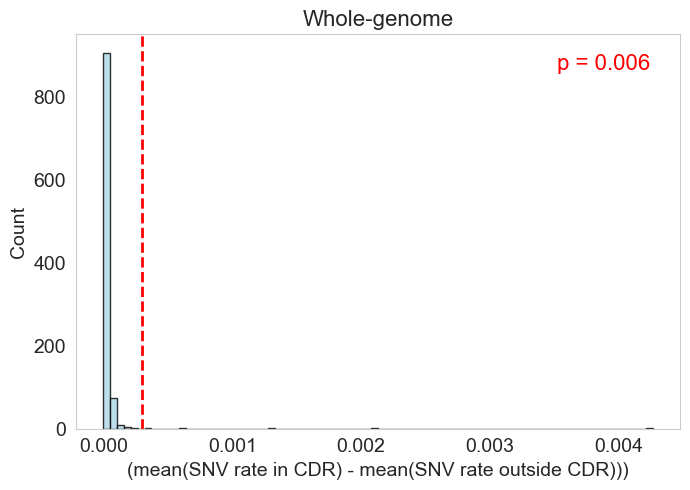

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Remove non-finite values
null_vals = null_distr[np.isfinite(null_distr)]

plt.figure(figsize=(7, 5))

# Plot null histogram
plt.hist(
    null_vals,
    bins=80,
    color='lightblue',
    edgecolor='black',
    alpha=0.8
)

# Determine colors based on p-value
if p_value < 0.01:
    line_color = 'red'
    p_text_color = 'red'
else:
    line_color = 'black'
    p_text_color = 'black'

# Plot observed test statistic
plt.axvline(
    test_stat,
    color=line_color,
    linestyle='--',
    linewidth=2
)

# Add p-value text (upper right, fixed decimal)
plt.text(
    0.95, 0.95,
    f"p = {p_value:.3f}",
    transform=plt.gca().transAxes,
    fontsize=16,
    color=p_text_color,
    ha='right',
    va='top'
)

plt.xlabel("(mean(SNV rate in CDR) - mean(SNV rate outside CDR)))", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Whole-genome", fontsize=16)

# Increase tick sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.show()


### Plotting the whole genome results

### Per-chrom permutations

In [20]:
import numpy as np

N_REPS = 1000

# Get all chromosomes present in the data
chromosomes = filtered_pairs_df['chr'].unique()

# Dictionary to hold null distributions per chromosome
nulls_per_chr = {}

for chr_ in chromosomes:
    print(f"Processing chromosome {chr_}")
    
    # Subset to pairs in this chromosome
    chr_pairs_df = filtered_pairs_df[filtered_pairs_df['chr'] == chr_]
    
    # Prepare one independent RNG per pair in this chromosome
    pair_rngs = {}
    for idx, r in enumerate(chr_pairs_df.itertuples(index=False)):
        s1, s2, pair, chr_tmp = r
        pair_rngs[pair] = np.random.default_rng(42 + idx)
    
    # Array to hold null distribution for this chromosome
    null_distr = np.empty(N_REPS)
    
    for rep in range(N_REPS):
        fake_in_rates = []
        fake_out_rates = []

        for r in chr_pairs_df.itertuples(index=False):
            s1, s2, pair, chr_tmp = r

            # Skip if either sample has no real CDRs
            if (
                (s1, chr_) not in real_cdr_intervals
                or (s2, chr_) not in real_cdr_intervals
                or len(real_cdr_intervals[(s1, chr_)]) == 0
                or len(real_cdr_intervals[(s2, chr_)]) == 0
            ):
                continue

            for sample in (s1, s2):
                key = (sample, chr_)
                full_key = (sample, chr_, pair)

                if (
                    key not in asat_bounds
                    or full_key not in snv_pos
                    or full_key not in aligned_intervals
                ):
                    continue

                asat_start, asat_end = asat_bounds[key]
                real_cdrs = real_cdr_intervals[key]

                fake_cdr = random_intervals_like(
                    real_intervals=real_cdrs,
                    bounds=(asat_start, asat_end),
                    rng=pair_rngs[pair],
                    sample_info=f"{sample}, {chr_}, {pair}"
                )

                fake_outside = complement_intervals(fake_cdr, (asat_start, asat_end))

                pos = snv_pos[full_key]
                aln = aligned_intervals[full_key]

                rate_in = snv_rate(pos, aln, fake_cdr)
                rate_out = snv_rate(pos, aln, fake_outside)

                if np.isfinite(rate_in) and np.isfinite(rate_out):
                    fake_in_rates.append(rate_in)
                    fake_out_rates.append(rate_out)

        # Store mean difference in null distribution
        null_distr[rep] = np.mean(fake_in_rates) - np.mean(fake_out_rates)

    # Save null distribution for this chromosome
    nulls_per_chr[chr_] = null_distr

print("Done! Null distributions per chromosome are stored in `nulls_per_chr`.")

Processing chromosome chr6
Processing chromosome chr19
Processing chromosome chr15
Processing chromosome chr17
Processing chromosome chrY
Processing chromosome chr18
Processing chromosome chr9
Processing chromosome chr11
Processing chromosome chr8
Processing chromosome chr12
Processing chromosome chrX
Processing chromosome chr3
Processing chromosome chr7
Processing chromosome chr22
Processing chromosome chr16
Processing chromosome chr4
Processing chromosome chr10
Processing chromosome chr20
Processing chromosome chr13
Processing chromosome chr21
Processing chromosome chr2
Processing chromosome chr1
Processing chromosome chr14
Processing chromosome chr5
Done! Null distributions per chromosome are stored in `nulls_per_chr`.


In [21]:
import pandas as pd
import numpy as np

# Assuming nulls_per_chr is already filled as in your code
# nulls_per_chr[chrom] = array of shape (N_REPS,)

# First, make sure all arrays have the same length (should be N_REPS)
for chrom, arr in nulls_per_chr.items():
    assert len(arr) == N_REPS, f"{chrom} has wrong length!"

# Convert to a DataFrame: columns = chromosomes, rows = repetitions
nulls_df = pd.DataFrame({chrom: nulls_per_chr[chrom] for chrom in sorted(nulls_per_chr.keys())})

# Write to CSV
output_file = "/private/groups/patenlab/mira/01282026_null_distributions_per_chrom.csv"
nulls_df.to_csv(output_file, index=False)

print(f"Null distributions written to {output_file}")

Null distributions written to /private/groups/patenlab/mira/01282026_null_distributions_per_chrom.csv


In [47]:
nulls_df.head()

,chr1,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,...,chr22,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chrX,chrY
0,-0.000008,-0.000004,0.000029,0.000045,0.000003,0.000002,0.000049,0.000006,0.000036,-0.000076,...,0.000146,-0.000041,5.569961e-04,-0.000008,1.561903e-05,0.000008,0.000070,5.834939e-05,0.000030,0.000554
1,0.000017,-0.000050,0.000041,-0.000023,-0.000011,0.000019,-0.000039,0.000008,0.000003,-0.000037,...,0.000110,-0.000056,-1.228157e-04,0.000008,-4.811045e-05,0.000016,0.000069,-9.758973e-06,-0.000007,0.000273
2,-0.000037,0.000055,0.000053,-0.000033,0.000022,-0.000023,0.000065,0.000029,-0.000010,-0.000022,...,-0.000038,-0.000039,-7.833542e-07,-0.000011,-3.224982e-05,0.000040,0.000013,3.779933e-05,-0.000014,-0.000222
3,-0.000010,0.000101,0.000044,0.000070,-0.000017,-0.000003,0.000045,0.000231,-0.000069,0.000127,...,0.000069,0.000169,-1.976121e-04,0.000026,-6.215878e-07,0.000007,0.000007,5.429464e-05,0.000034,0.000305
4,0.000026,0.000018,0.000017,-0.000035,-0.000028,0.000092,-0.000043,0.000026,0.000034,-0.000048,...,0.000049,0.000123,2.838068e-05,0.000093,-4.439123e-07,0.000028,0.000124,6.383921e-07,0.000026,-0.000135


### Per chrom test statistic

In [ ]:
import pandas as pd
import numpy as np

# Prepare a list to store results
results = []

# Loop over chromosomes
for chrom in pairs_df['chr'].unique():
    print(f"Processing chromosome {chrom}")

    # Subset pairs_df to this chromosome
    chr_pairs_df = pairs_df[pairs_df['chr'] == chrom]

    # Lists to store per-pair rates
    real_in_rates = []
    real_out_rates = []

    # Loop over pairs
    for r in chr_pairs_df.itertuples(index=False):
        s1, s2, pair, chr_ = r
        # Skip pairs if either sample has no real CDRs
        if (
            (s1, chr_) not in real_cdr_intervals
            or (s2, chr_) not in real_cdr_intervals
            or len(real_cdr_intervals[(s1, chr_)]) == 0
            or len(real_cdr_intervals[(s2, chr_)]) == 0
        ):
            continue

        for sample in (s1, s2):
            key = (sample, chr_)
            full_key = (sample, chr_, pair)

            # Skip if missing required data
            if (
                key not in asat_bounds
                or full_key not in snv_pos
                or full_key not in aligned_intervals
            ):
                continue

            # Get real CDRs and ASAT bounds
            cdrs = real_cdr_intervals[key]
            asat_start, asat_end = asat_bounds[key]

            # Compute complement intervals
            outside = complement_intervals(cdrs, (asat_start, asat_end))

            pos = snv_pos[full_key]
            aln = aligned_intervals[full_key]

            # Compute SNV rates
            rate_in = snv_rate(pos, aln, cdrs)
            rate_out = snv_rate(pos, aln, outside)

            # Only keep finite values
            if np.isfinite(rate_in) and np.isfinite(rate_out):
                real_in_rates.append(rate_in)
                real_out_rates.append(rate_out)

    # Compute test statistic for this chromosome
    if len(real_in_rates) > 0 and len(real_out_rates) > 0:
        test_stat = np.mean(real_in_rates) - np.mean(real_out_rates)
    else:
        test_stat = np.nan  # if no valid pairs

    # Store result
    results.append({
        "chr": chrom,
        "n_pairs": len(chr_pairs_df),
        "n_rates": len(real_in_rates),  # number of SNV rates included
        "mean_in_rate": np.mean(real_in_rates) if real_in_rates else np.nan,
        "mean_out_rate": np.mean(real_out_rates) if real_out_rates else np.nan,
        "test_stat": test_stat
    })

# Convert to DataFrame
per_chrom_results_df = pd.DataFrame(results)

print(per_chrom_results_df)


Processing chromosome chr6
Processing chromosome chr19
Processing chromosome chr15
Processing chromosome chr17
Processing chromosome chrY
Processing chromosome chr18
Processing chromosome chr9
Processing chromosome chr11
Processing chromosome chr8
Processing chromosome chr12
Processing chromosome chrX
Processing chromosome chr3
Processing chromosome chr7
Processing chromosome chr22
Processing chromosome chr16
Processing chromosome chr4
Processing chromosome chr10
Processing chromosome chr20
Processing chromosome chr13
Processing chromosome chr21
Processing chromosome chr2
Processing chromosome chr1
Processing chromosome chr14
Processing chromosome chr5
      chr  n_pairs  n_rates  mean_in_rate  mean_out_rate  test_stat
0    chr6       33       57      0.000876       0.000419   0.000457
1   chr19      235      305      0.002250       0.001164   0.001086
2   chr15       99      144      0.000663       0.000527   0.000136
3   chr17       22       32      0.000564       0.000561   0.000002

In [ ]:
import pandas as pd
import numpy as np

# Copy the results df to add p-values
per_chrom_results_df = per_chrom_results_df.copy()
per_chrom_results_df["p_value"] = np.nan

# Loop over chromosomes
for chrom in per_chrom_results_df["chr"]:
    # Real test statistic
    test_stat = per_chrom_results_df.loc[per_chrom_results_df["chr"] == chrom, "test_stat"].values[0]

    # Null distribution for this chromosome
    null_distr = nulls_df[chrom].values

    # Compute p-value: fraction of null >= observed test statistic
    # For two-tailed: np.mean(np.abs(null_distr) >= abs(test_stat))
    p_value = np.mean(np.abs(null_distr) >= abs(test_stat))

    if p_value == 0:
        p_value = 1 / len(null_distr)

    # Store
    per_chrom_results_df.loc[per_chrom_results_df["chr"] == chrom, "p_value"] = p_value

for _, row in per_chrom_results_df.iterrows():
    chrom = row['chr']
    test_stat = row['test_stat']
    p_value = row['p_value']

    # Format p-value
    if p_value < 1e-5:
        p_str = f"{p_value:.2e}"   # scientific notation with 2 decimals
    else:
        p_str = f"{p_value:.6f}"   # fixed point, 6 decimals

    print(f"{chrom}  test_stat: {test_stat:.6f}  p_value: {p_str}")





chr6  test_stat: 0.000457  p_value: 0.000999
chr19  test_stat: 0.001086  p_value: 0.002997
chr15  test_stat: 0.000136  p_value: 0.017982
chr17  test_stat: 0.000002  p_value: 0.452547
chrY  test_stat: -0.000194  p_value: 0.809191
chr18  test_stat: -0.000010  p_value: 0.469530
chr9  test_stat: 0.000081  p_value: 0.030969
chr11  test_stat: 0.000273  p_value: 0.004995
chr8  test_stat: 0.000146  p_value: 0.059940
chr12  test_stat: 0.000335  p_value: 0.000999
chrX  test_stat: 0.000449  p_value: 0.003996
chr3  test_stat: -0.000067  p_value: 0.860140
chr7  test_stat: 0.000227  p_value: 0.003996
chr22  test_stat: 0.000133  p_value: 0.041958
chr16  test_stat: 0.000332  p_value: 0.000999
chr4  test_stat: 0.000038  p_value: 0.298701
chr10  test_stat: 0.000240  p_value: 0.002997
chr20  test_stat: -0.000055  p_value: 0.978022
chr13  test_stat: 0.000325  p_value: 0.009990
chr21  test_stat: -0.000078  p_value: 0.961039
chr2  test_stat: 0.000668  p_value: 0.006993
chr1  test_stat: 0.000220  p_value: 0.

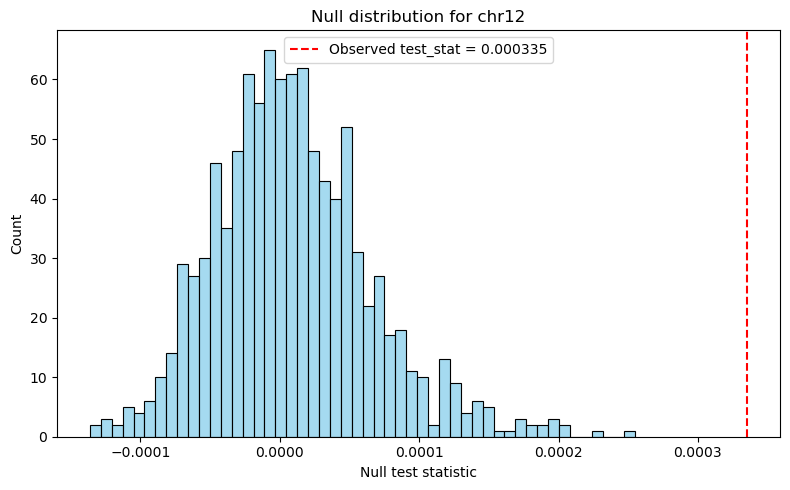

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the null distribution for chr12
null_chr12 = nulls_df['chr12'].values

# Get the observed test statistic for chr12
test_stat_chr12 = per_chrom_results_df.loc[per_chrom_results_df['chr'] == 'chr12', 'test_stat'].values[0]

# Plot
plt.figure(figsize=(8,5))
sns.histplot(null_chr12, bins=50, color='skyblue', kde=False)
plt.axvline(test_stat_chr12, color='red', linestyle='--', label=f"Observed test_stat = {test_stat_chr12:.6f}")

plt.xlabel("Null test statistic")
plt.ylabel("Count")
plt.title("Null distribution for chr12")
plt.legend()
plt.tight_layout()
plt.show()


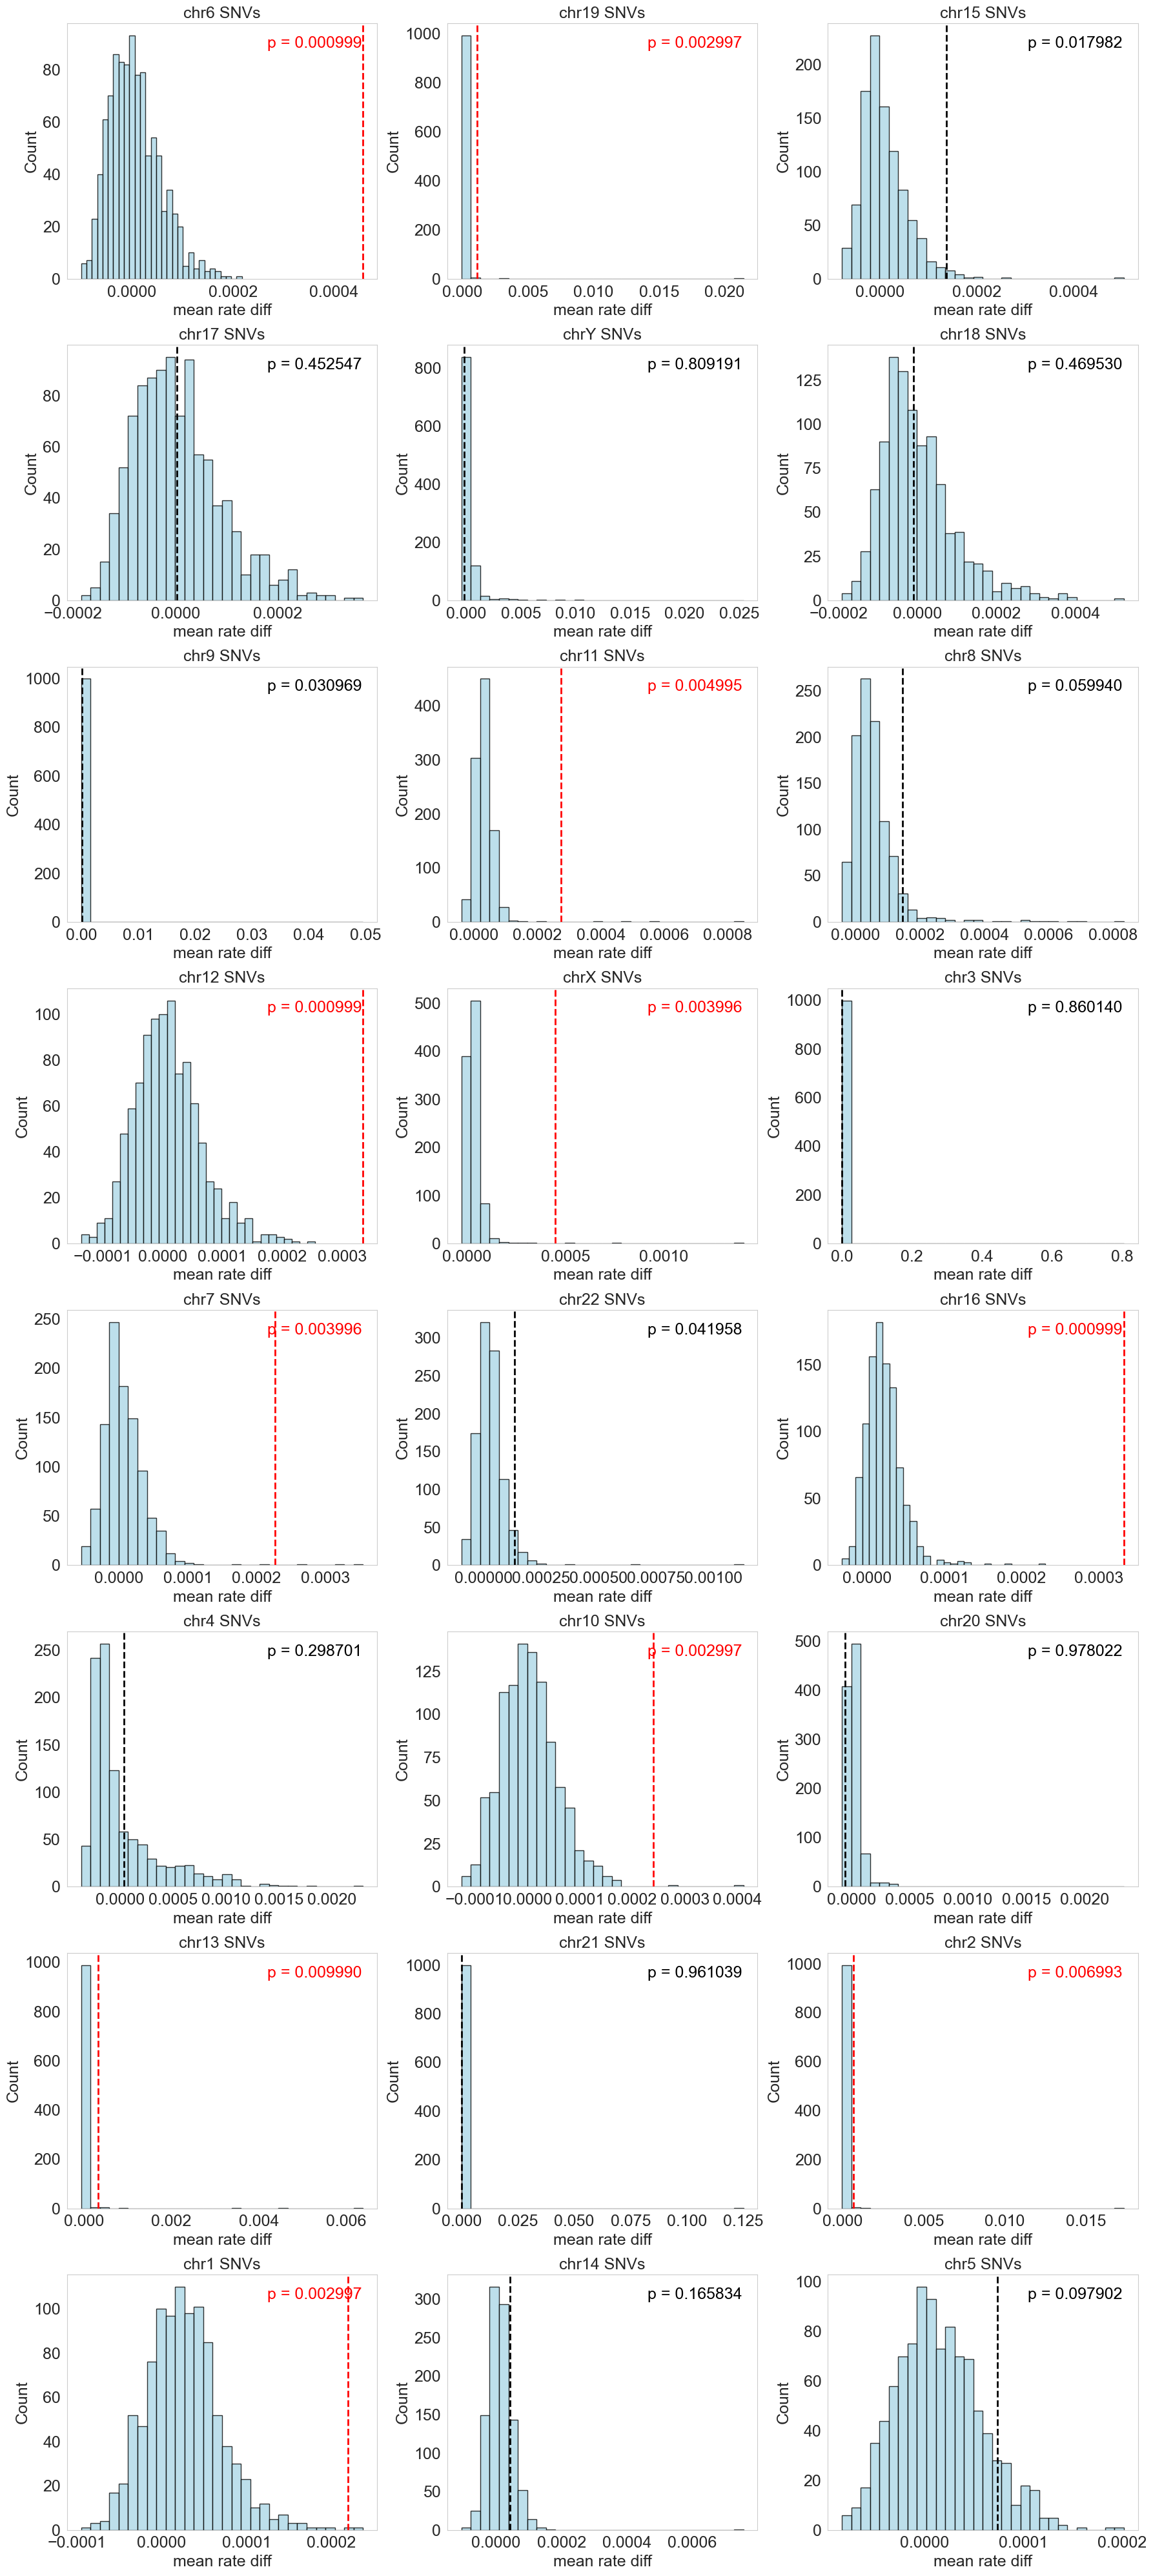

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Get chromosomes and layout
chromosomes = per_chrom_results_df['chr'].tolist()
n_chroms = len(chromosomes)
cols = 3
rows = int(np.ceil(n_chroms / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5), squeeze=False)

for idx, chrom in enumerate(chromosomes):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    
    # Null distribution and test stat
    null_vals = nulls_df[chrom].values
    test_stat = per_chrom_results_df.loc[
        per_chrom_results_df['chr'] == chrom, 'test_stat'
    ].values[0]
    p_val = per_chrom_results_df.loc[
        per_chrom_results_df['chr'] == chrom, 'p_value'
    ].values[0]
    
    # Plot null histogram
    ax.hist(
        null_vals,
        bins=30,
        color='lightblue',
        edgecolor='black',
        alpha=0.8
    )
    
    # Color based on significance
    if p_val < 0.01:
        line_color = 'red'
        p_text_color = 'red'
    else:
        line_color = 'black'
        p_text_color = 'black'
    
    # Format p-value text
    if p_val < 1e-5:
        p_text = f"p = {p_val:.2e}"
    else:
        p_text = f"p = {p_val:.6f}"
    
    # Plot observed test statistic
    ax.axvline(test_stat, color=line_color, linestyle='--', linewidth=2)
    
    # Add p-value text
    ax.text(
        0.95, 0.95,
        p_text,
        transform=ax.transAxes,
        fontsize=18,
        color=p_text_color,
        ha='right',
        va='top'
    )
    
    ax.set_title(f"{chrom} SNVs", fontsize=18)
    ax.set_xlabel("mean rate diff", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)

    # Tick sizes
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    ax.grid(False)

# Hide empty subplots
for idx in range(n_chroms, rows * cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()





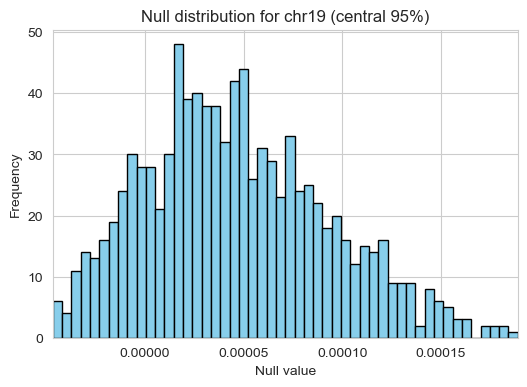

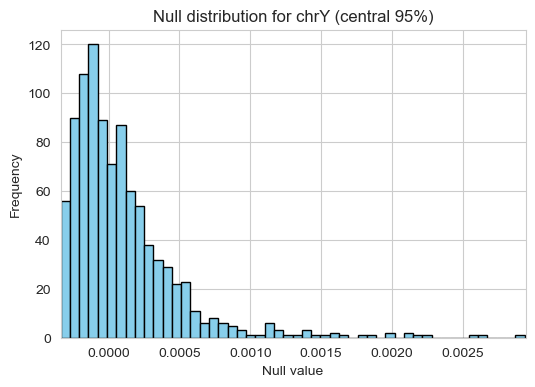

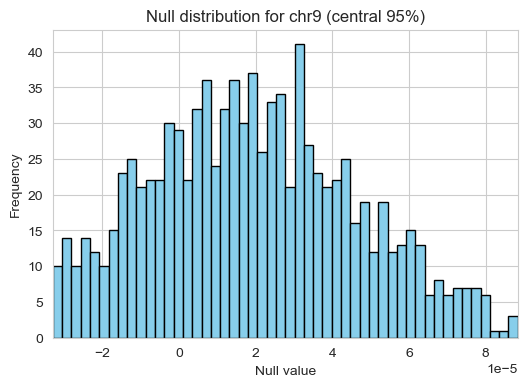

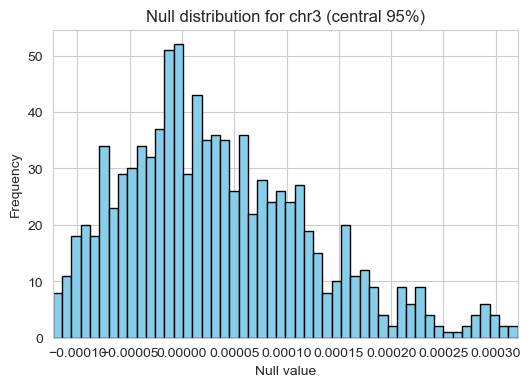

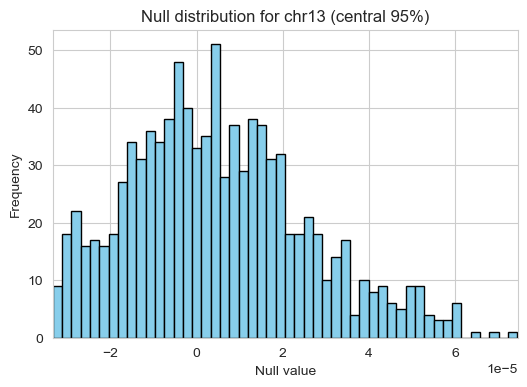

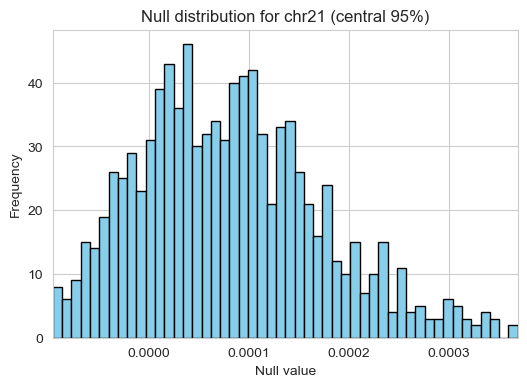

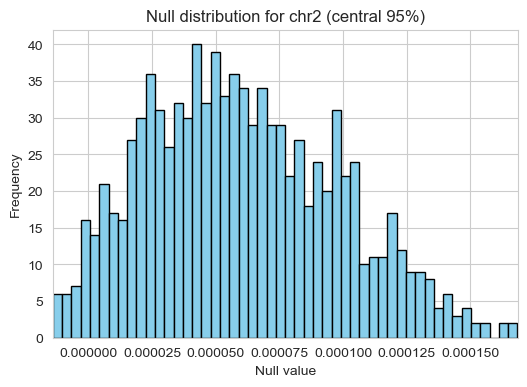

In [38]:
import matplotlib.pyplot as plt
import numpy as np

chromosomes_to_plot = ["chr19", "chrY", "chr9", "chr3", "chr13", "chr21", "chr2"]

for chr_ in chromosomes_to_plot:
    null_distr_chr = nulls_per_chr[chr_]

    # Remove non-finite values
    null_distr_chr = null_distr_chr[np.isfinite(null_distr_chr)]
    if len(null_distr_chr) == 0:
        print(f"No valid data for {chr_}, skipping.")
        continue

    # Compute 2.5th and 97.5th percentiles
    lower, upper = np.percentile(null_distr_chr, [2.5, 97.5])

    # Clip data to 95% central range
    clipped_data = null_distr_chr[(null_distr_chr >= lower) & (null_distr_chr <= upper)]

    plt.figure(figsize=(6, 4))
    plt.hist(clipped_data, bins=50, color="skyblue", edgecolor="k")
    plt.title(f"Null distribution for {chr_} (central 95%)")
    plt.xlabel("Null value")
    plt.ylabel("Frequency")

    # Optionally, explicitly set limits to exactly the clipped range
    plt.xlim(lower, upper)

    plt.show()



### Debugging 

In [62]:
# Threshold
threshold = 0.2

# List of entries exceeding threshold
high_density = []

for key in real_cdr_intervals:
    if key not in asat_bounds:
        continue
    sample, chr_ = key
    cdrs = real_cdr_intervals[key]
    bounds_start, bounds_end = asat_bounds[key]
    total_cdr_bases = sum(end - start for start, end in cdrs)
    total_bounds_bases = bounds_end - bounds_start
    prop = total_cdr_bases / total_bounds_bases
    if prop > threshold:
        high_density.append((sample, chr_, prop))

# Sort descending by proportion
high_density_sorted = sorted(high_density, key=lambda x: x[2], reverse=True)

# Print
print(f"(sample, chr) entries with > {threshold*100:.0f}% CDR density:")
for sample, chr_, prop in high_density_sorted:
    print(f"{sample}, {chr_}: {prop:.3f}")

print(f"Total entries above {threshold*100:.0f}%: {len(high_density_sorted)}")


(sample, chr) entries with > 20% CDR density:
HG00423.2, chr4: 0.463
HG01530.2, chr4: 0.419
HG00320.2, chr4: 0.414
HG00128.1, chr4: 0.403
HG00408.2, chr4: 0.391
HG04115.2, chr4: 0.371
HG01784.2, chr4: 0.311
HG00126.2, chr4: 0.309
HG03831.1, chr21: 0.244
HG02723.1, chr4: 0.244
HG00738.2, chr21: 0.243
HG03017.1, chrY: 0.230
HG01934.1, chrY: 0.227
HG02083.1, chrY: 0.221
HG02523.2, chr13: 0.217
HG01192.1, chrY: 0.217
HG01261.2, chr2: 0.217
HG04204.1, chr15: 0.213
HG00621.1, chrY: 0.210
HG02165.2, chr15: 0.203
Total entries above 20%: 20


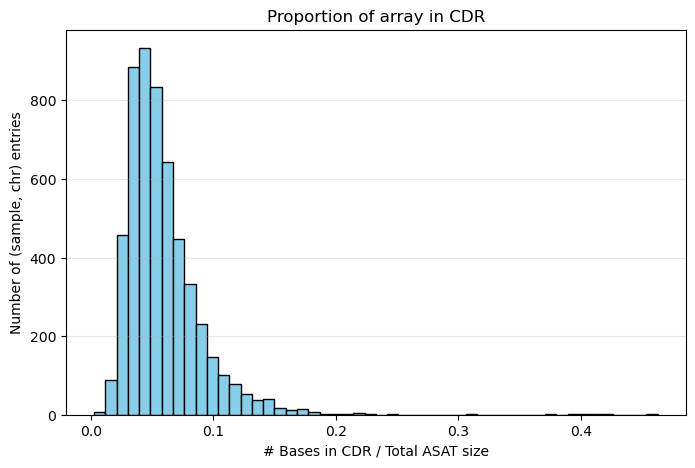

In [64]:
import matplotlib.pyplot as plt

# Compute proportions
proportions = []
for key in real_cdr_intervals:
    if key not in asat_bounds:
        continue
    cdrs = real_cdr_intervals[key]
    bounds_start, bounds_end = asat_bounds[key]
    total_cdr_bases = sum(end - start for start, end in cdrs)
    total_bounds_bases = bounds_end - bounds_start
    proportions.append(total_cdr_bases / total_bounds_bases)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(proportions, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("# Bases in CDR / Total ASAT size")
plt.ylabel("Number of (sample, chr) entries")
plt.title("Proportion of array in CDR")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [55]:
print(asat_bounds)

{('HG02572.1', 'chr2'): (92088720, 94028031), ('HG02572.1', 'chr7'): (60815527, 63871369), ('HG02572.1', 'chr8'): (44232206, 46352903), ('HG02572.1', 'chr9'): (42616238, 44955099), ('HG02572.1', 'chr11'): (50957725, 52118575), ('HG02572.1', 'chr13'): (11342848, 12879738), ('HG02572.1', 'chr14'): (10697072, 13860919), ('HG02572.1', 'chr15'): (7702020, 8601968), ('HG02572.1', 'chr16'): (34100966, 36081983), ('HG02572.1', 'chr19'): (25539653, 28704245), ('HG02572.1', 'chr20'): (27363618, 30021264), ('HG02572.1', 'chr21'): (5075354, 7241107), ('HG02572.1', 'chrY'): (9860231, 10751486), ('HG02572.1', 'chr3'): (91828348, 95558641), ('HG03470.1', 'chr1'): (121482871, 124951682), ('HG03470.1', 'chr2'): (92654212, 94441165), ('HG03470.1', 'chr7'): (60551641, 63172672), ('HG03470.1', 'chr8'): (43798429, 45937883), ('HG03470.1', 'chr9'): (44940753, 47630217), ('HG03470.1', 'chr10'): (39587882, 41368607), ('HG03470.1', 'chr11'): (50958731, 55095717), ('HG03470.1', 'chr12'): (34670641, 37697004), (

In [51]:
## Debug chr 4 

real = [(50902094, 51005470), (51016194, 51064291), (51108649, 51123112), (51191112, 52559454)]
bounds = (49946033, 53263026)
rng = np.random.default_rng(42)

random_intervals_like(
                real_intervals=real,
                bounds=bounds,
                rng=rng)

[(np.int64(50232851), np.int64(50336227)),
 (np.int64(50338627), np.int64(51706969)),
 (np.int64(52107775), np.int64(52122238)),
 (np.int64(52476015), np.int64(52524112))]

In [5]:
cdr_idx="/private/groups/migalab/jmmenend/HPRC/cenSatProject/CDR_data/hprc_ont_centrodip_output_data_index.csv"
cdr_idx_df = pd.read_csv(cdr_idx)
print(cdr_idx_df["centrodip_final"][0])

/private/groups/migalab/jmmenend/HPRC/cenSatProject/CDR_data/processing/HG00408/analysis/hprc_centrodip_outputs/05e12c7e-5427-44c1-b696-6671ae9f98c0/HG00408_mat_hprc_r2_v1.0.1.centrodip.bed


In [5]:
import pandas as pd
import os

# Read CDR index
cdr_idx = "/private/groups/migalab/jmmenend/HPRC/cenSatProject/CDR_data/hprc_ont_centrodip_output_data_index.csv"
cdr_idx_df = pd.read_csv(cdr_idx, usecols=["sample_id", "haplotype", "centrodip_final"])
cdr_idx_df["sample"] = cdr_idx_df["sample_id"] + "." + cdr_idx_df["haplotype"].astype(str)

# Build contig -> (sample, chr) lookup from asat_df
contig_to_sample_chr = {}
for row in asat_df.itertuples(index=False):
    contig_to_sample_chr[row.contig] = (row.sample, row.chr)

# Read CDR beds and assign chr via contig matching
cdr_dfs = []
missing = 0

for row in cdr_idx_df.itertuples(index=False):
    bed_path = row.centrodip_final
    sample = row.sample

    if not os.path.exists(bed_path):
        missing += 1
        continue

    bed = pd.read_csv(bed_path, sep="\t", header=None, usecols=[0, 1, 2],
                       names=["contig", "start", "end"])

    # Keep only contigs that appear in asat_df for this sample
    bed = bed[bed["contig"].isin(contig_to_sample_chr)]
    bed["sample"] = bed["contig"].map(lambda c: contig_to_sample_chr[c][0])
    bed["chr"] = bed["contig"].map(lambda c: contig_to_sample_chr[c][1])

    # Only keep rows where the sample matches
    bed = bed[bed["sample"] == sample]

    if len(bed) > 0:
        cdr_dfs.append(bed)

cdr_df = pd.concat(cdr_dfs, ignore_index=True)
print(f"Missing bed files: {missing}")
print(f"CDR entries: {len(cdr_df)}, samples: {cdr_df['sample'].nunique()}")
cdr_df.head()


Missing bed files: 0
CDR entries: 13956, samples: 231


,contig,start,end,sample,chr
0,HG00408#2#CM085965.1,92912040,92943572,HG00408.2,chr2
1,HG00408#2#CM085965.1,93119473,93144229,HG00408.2,chr2
2,HG00408#2#CM085965.1,93211123,93259059,HG00408.2,chr2
3,HG00408#2#CM085965.1,93280225,93293988,HG00408.2,chr2
4,HG00408#2#CM085965.1,93298132,93334372,HG00408.2,chr2


In [16]:
# Get chrY entries from asat_df
chrY_asat = asat_df[asat_df["chr"] == "chrY"][["sample", "contig"]].copy()

# Build sample -> centrodip_final path lookup
sample_to_bed = dict(zip(cdr_idx_df["sample"], cdr_idx_df["centrodip_final"]))

results = []
for row in chrY_asat.itertuples(index=False):
    sample, contig = row.sample, row.contig
    bed_path = sample_to_bed.get(sample)
    
    if bed_path is None:
        results.append((sample, contig, "no_cdr_idx_entry"))
    elif not os.path.exists(bed_path):
        results.append((sample, contig, "bed_file_missing"))
    else:
        bed = pd.read_csv(bed_path, sep="\t", header=None, usecols=[0], names=["contig_in_bed"])
        if contig in bed["contig_in_bed"].values:
            results.append((sample, contig, "FOUND"))
        else:
            results.append((sample, contig, "contig_not_in_bed"))

result_df = pd.DataFrame(results, columns=["sample", "contig", "status"])
print(result_df["status"].value_counts())
print()
print(result_df.to_string(index=False))


status
contig_not_in_bed    43
no_cdr_idx_entry      2
Name: count, dtype: int64

   sample                      contig            status
HG02572.1 HG02572#1#JAHAOW020000041.1 contig_not_in_bed
HG04160.1 HG04160#1#JBHIGW010000007.1 contig_not_in_bed
HG00621.1        HG00621#1#CM087861.1 contig_not_in_bed
NA20809.1 NA20809#1#JBIRDZ010000019.1 contig_not_in_bed
HG00126.1 HG00126#1#JBHIKU010000040.1 contig_not_in_bed
NA20762.1 NA20762#1#JBKOQW010000006.1 contig_not_in_bed
NA18960.1 NA18960#1#JBKABY010000023.1 contig_not_in_bed
NA21093.1 NA21093#1#JBHIJC010000064.1 contig_not_in_bed
HG01261.1        HG01261#1#CM085914.1 contig_not_in_bed
HG01358.1 HG01358#1#JAGYZB020000063.1 contig_not_in_bed
HG03098.1 HG03098#1#JAHEPM020000017.1 contig_not_in_bed
NA18944.1        NA18944#1#CM101657.1 contig_not_in_bed
  CHM13.0                        chrY  no_cdr_idx_entry
HG02984.1 HG02984#1#JBJKOM010000044.1 contig_not_in_bed
HG00642.1        HG00642#1#CM086617.1 contig_not_in_bed
HG02083.1 HG02083#1#JB

In [6]:
# Check if chrY exists in asat_df
print("chrY in asat_df:", "chrY" in asat_df["chr"].values)

# Check if any CDR bed contigs map to chrY
print("chrY in cdr_df chr values:", cdr_df["chr"].unique())


chrY in asat_df: True
chrY in cdr_df chr values: ['chr2' 'chr9' 'chr4' 'chr5' 'chr8' 'chr16' 'chr13' 'chr6' 'chr11' 'chr12'
 'chr21' 'chr18' 'chr20' 'chr22' 'chr19' 'chr7' 'chr10' 'chr14' 'chrX'
 'chr1' 'chr15' 'chr3' 'chr17']


In [15]:
asat_df[asat_df["chr"] == "chrY"][["sample", "contig", "start", "end"]].to_csv(
    "chrY_asat_contigs.txt", sep="\t", index=False
)


### write out a per-chrom bed file containing only the CDR entries for contigs used in centrolign 


In [18]:
output_dir = "/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26"  # change this
os.makedirs(output_dir, exist_ok=True)

for chrom, group in cdr_df.groupby("chr"):
    out_path = os.path.join(output_dir, f"{chrom}_CDRs.bed")
    group[["contig", "start", "end", "sample"]].to_csv(out_path, sep="\t", header=False, index=False)
    print(f"  {chrom}: {len(group)} entries -> {out_path}")

  chr1: 804 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr1_CDRs.bed
  chr10: 714 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr10_CDRs.bed
  chr11: 836 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr11_CDRs.bed
  chr12: 775 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr12_CDRs.bed
  chr13: 455 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr13_CDRs.bed
  chr14: 706 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr14_CDRs.bed
  chr15: 618 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr15_CDRs.bed
  chr16: 912 entries -> /private/groups/patenlab/mira/centrolign/analys